In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
from scipy import optimize
import matplotlib.mlab as mlab
%matplotlib inline

# pp-SRC analysis

In [2]:
targets = ['C12','Al27','Fe56','Pb208']
colors = ['red','blue','purple','black']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'] 

In [3]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] 
root_fname , data_allPmiss_PrecFid , ana = dict() , dict() , dict()
for target in targets:
    root_fname[target] = path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target
    data_allPmiss_PrecFid[target] = read_root( root_fname[target] , columns=columns )
    ana[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

columns = ['Q2' , 'Xb' , 'p/q' ,'theta (pq)' , 'Mmiss' ,'Pmiss3Mag','pcmX','pcmY','pcmZ' , 'rooWeight' ,
          'theta (rec-q)' , 'OpeningAngle']
targets = ['C12','Al27','Fe56','Pb208']
colors = ['red','blue','purple','black']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'] 
ana = dict()
for target in targets:
    ana[target] = read_root( "/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target , key='anaTree' , columns=columns  )

In [4]:
def gauss_func(x, C , mean, sigma):
    return C/np.sqrt(2*np.pi*sigma)*np.exp( -np.square(x-mean)/(2*np.square(sigma)) )

# runs 10,000 - 72,500
AccCorr = pd.DataFrame({'A':[12 , 27 , 56 , 208],
                        's_t_AccCorr':[160,157,182,175],
                        's_t_AccCorrErr':[9,18,9,15]},index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
# c.m. resolution correction
AccCorr['s_t_final'] = np.sqrt( np.square(AccCorr['s_t_AccCorr']) - np.square(20))
AccCorr['s_t_final_Err'] = np.sqrt( np.square(AccCorr['s_t_AccCorrErr']) + np.square(5))

AccCorr

In [20]:
# results from Analysis_alaHalla_different_targets_bands.ipynb 
# Aug 9, 2017
AccCorr = pd.DataFrame({'A':[12 , 27 , 56 , 208],
                        's_t_measured':[160,174,182,180],
                        's_t_measured_Err':[5,9,6,13],
                        's_t_final':[149,163,168,170],
                        's_t_final_Err':[7,15,10,23]}
                       ,index = target_names)
AccCorr

,A,s_t_final,s_t_final_Err,s_t_measured,s_t_measured_Err
$^{12}$C,12,149,7,160,5
$^{27}$Al,27,163,15,174,9
$^{56}$Fe,56,168,10,182,6
$^{208}$Pb,208,170,23,180,13


In [6]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials"]: # ,"NoPrecFiducials"
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['mean_t'] = 0.5*(cm_pars['mean_x_unweighted']+cm_pars['mean_y_unweighted'])
    cm_pars['sigma_t'] = 0.5*(cm_pars['sigma_x_unweighted']+cm_pars['sigma_y_unweighted'])

    cm_pars['sigma_tErr'] = 0.5*np.sqrt( np.square(cm_pars['sigma_xErr_unweighted']) + np.square(cm_pars['sigma_yErr_unweighted']) )
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars

C12 sigma: 158 MeV/c
Al27 sigma: 181 MeV/c
Fe56 sigma: 179 MeV/c
Pb208 sigma: 196 MeV/c


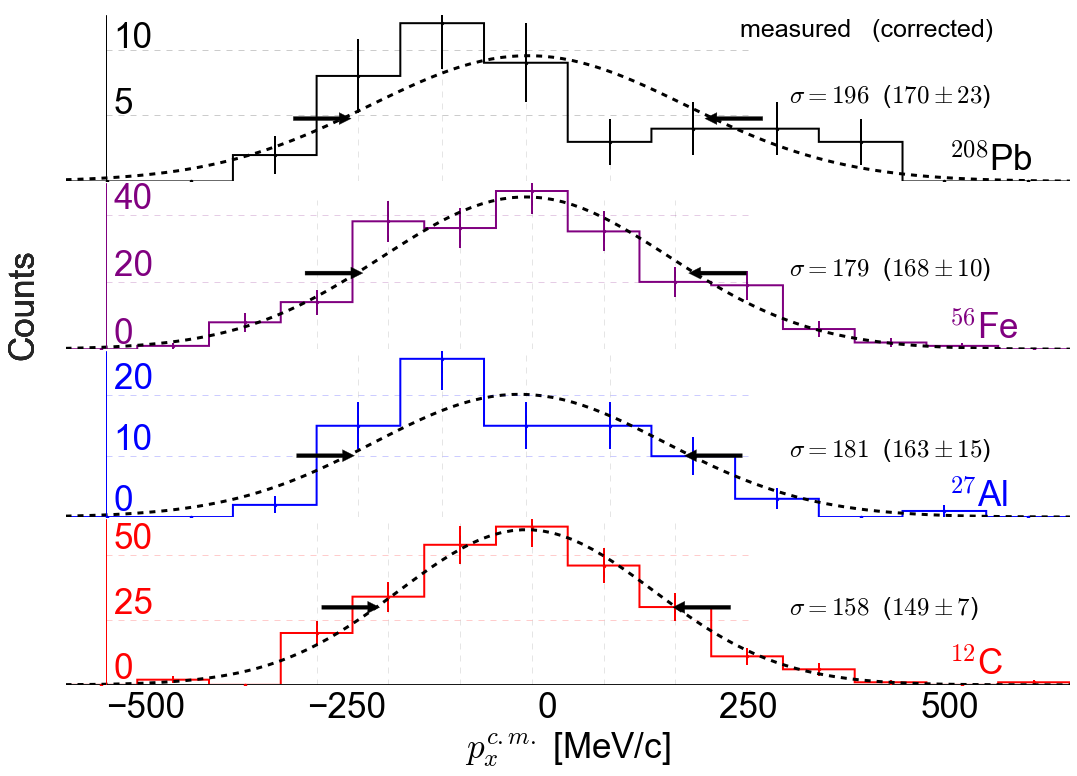

In [29]:
# make p(c.m.) in a nice style using also keyone
xmin , xmax  = -600,650
fontsize = 35
gauscolor = 'black'
figsize=(18,12)
fig = plt.figure(figsize=figsize)
nbins = [15 , 13 , 15 , 13]
y_ticks_targets = [[0, 25, 50],[0, 10, 20],[0, 20, 40],[5, 10]]
y_text_sigma = [27,10,22,6]

for i,target,target_name,color,y_ticks in zip(range(4)
                                              ,targets,target_names,colors,y_ticks_targets):
    bins = np.linspace(xmin , xmax , nbins[i] )

    x = 1000*ana[target].pcmX #np.sqrt(0.5)*(ana[target].pcmX + ana[target].pcmY)
    x_label = '$p^{c.m.}_{x}$ [MeV/c]' if target is 'C12' else '' # = (p^{c.m.}_{x}+p^{c.m.}_{y})/2
#     x = 1000*np.sqrt(0.5)*(ana[target]['pcmX'] + ana[target]['pcmY'])
#     x_label = '$\\frac{1}{2}(p^{c.m.}_{x}+p^{c.m.}_{y})$ [MeV/c]' if target is 'C12' else '' 

    mean = np.average(x)
    sigma = np.sqrt(np.average(np.square(x-mean)))   
    ax = fig.add_subplot(4,1,4-i)
    h,bins,_=plt.hist(x,bins=bins,histtype='step',linewidth=2,color=color);
    mid = bins[0:-1] + 0.5*(bins[1]-bins[0])
    plt.errorbar( mid , y=h , yerr=np.sqrt(h) , fmt='.',linewidth=2 , color=color);
    C = np.max(h)

    mean = np.mean(x)
    sigma = np.std(x)
    print target,'sigma: %.0f MeV/c'%(sigma)
    x_gaus = np.linspace(np.min(bins),np.max(bins),100)
    norm_fact = len(x)*(bins[1]-bins[0])
    y_gaus = norm_fact*mlab.normpdf(x_gaus, mean, sigma)
    y_sigma = 0.5*np.max(y_gaus)
    plt.plot(x_gaus,y_gaus,'--',color=gauscolor,linewidth=3);
    ymax = 1.05*np.max(h)
    ax.set_ylim(0,ymax)
    if i==0: plt.axhspan(xmin=-1,xmax=1,ymin=0,ymax=0,linewidth=3)
    else:
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.set_axis_off()
    plt.text(xmax-150 , 0.07*np.max(h) , target_name , color=color , fontsize=35)
    ax.set_xlim(xmin , xmax)
    plt.xticks(np.linspace(xmin + 200 , xmax - 200 , 5))
    set_axes(ax,x_label=x_label,fontsize=35)
    plt.subplots_adjust(hspace=0.01)
    # add grid lines
    for j,tick in zip(range(len(mid)),mid):
        if j < 3 or j > nbins[i]-7: continue 
        if i==2  :  y_max = 0.9*ymax # h[j]
        elif i==3:  y_max = h[j]
        else: y_max = ymax
        line = plt.Line2D([tick,tick],[0,y_max],linewidth=1,linestyle='--',color='black',alpha=0.1)
        ax.add_artist(line)
    # add x-axis to the bottom subplot (12C)
    if i==0:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(labeltop='off', labelleft='off')
        customaxis(ax,c_left='none',c_bottom='none')
    # add vertical axes
    x_yaxis = -550 # xmin + 167.5*(xmax-xmin)*(1-0.2*i*0)
    line = plt.Line2D([x_yaxis,x_yaxis],[0,ymax],linewidth=1,linestyle='-',color=color)
    ax.add_artist(line)
    for y_tick in y_ticks: 
        ax.text(x_yaxis+10,y_tick+0.04*y_max,'%d'%y_tick,fontsize=fontsize,color=color)
        line = plt.Line2D([x_yaxis,-x_yaxis-300],[y_tick,y_tick],linewidth=1,linestyle='--',color=color,alpha=0.2)
        ax.add_artist(line)

    # add sigma lines and text
    s_t_final , s_t_final_Err = float(AccCorr[AccCorr.index==target_name]['s_t_final']),float(AccCorr[AccCorr.index==target_name]['s_t_final_Err'])
    
    x_text = xmax - 350 # mean+sigma+110
    #y_text = y_sigma+3 if i!=1 else y_sigma-2
    if target is 'Pb208': plt.text( x_text-60 , y_text_sigma[i]+5,'measured   (corrected)',color=gauscolor,fontsize=25)
    plt.text(x_text, y_text_sigma[i],'$\\sigma=%.0f $  ($%.0f \pm %.0f $)'%(sigma , s_t_final , s_t_final_Err),color=gauscolor,fontsize=25)
    ax.annotate('', xy=(mean+sigma+20, y_sigma), xytext=(mean+sigma+100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    ax.annotate('', xy=(mean-sigma-20, y_sigma), xytext=(mean-sigma-100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    plt.xticks([-500, -250, 0, 250, 500])
    plt.figtext(0.08,0.6,"Counts",fontdict={'fontsize':fontsize},rotation=90)
    # plt.tight_layout()
    plt.savefig('/Users/erezcohen/Desktop/Projects/2NSRC/ppCMpaper/Figures/pcm_alltargets.png',transparent=True)         

C12 sigma: 158 MeV/c
Al27 sigma: 181 MeV/c
Fe56 sigma: 179 MeV/c
Pb208 sigma: 196 MeV/c


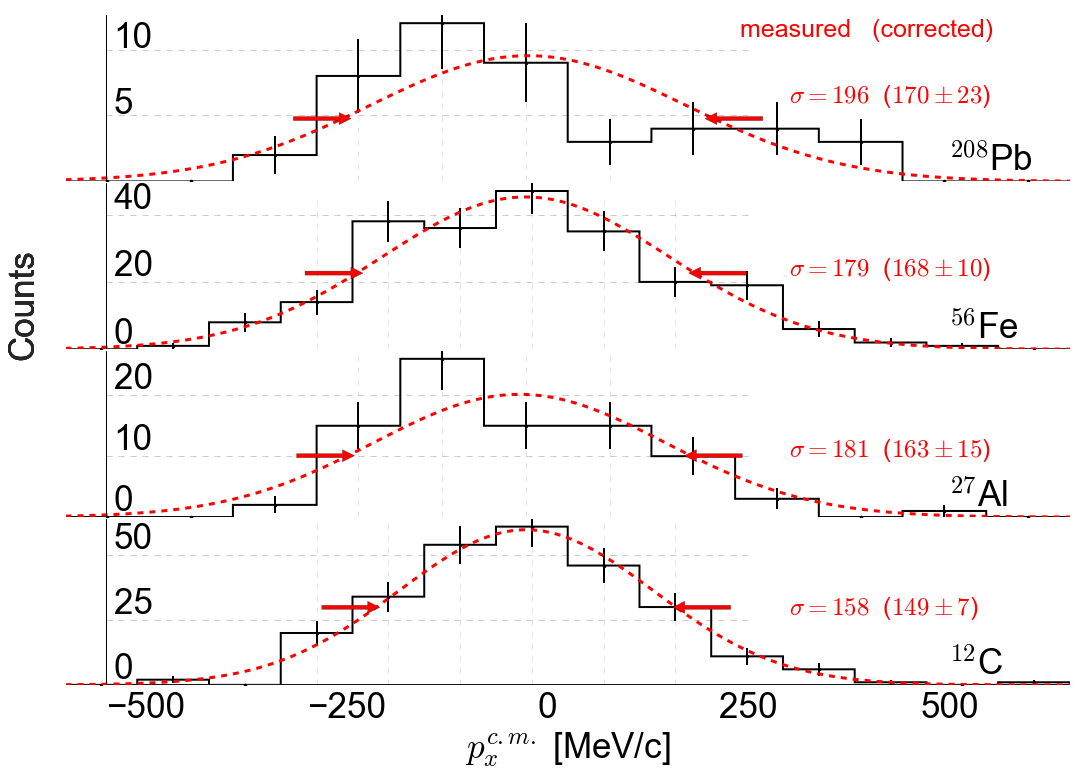

In [30]:
# make p(c.m.) in a nice style using also keyone
xmin , xmax  = -600,650
fontsize = 35
gauscolor = 'red'
figsize=(18,12)
fig = plt.figure(figsize=figsize)
nbins = [15 , 13 , 15 , 13]
y_ticks_targets = [[0, 25, 50],[0, 10, 20],[0, 20, 40],[5, 10]]
y_text_sigma = [27,10,22,6]

for i,target,target_name,color,y_ticks in zip(range(4)
                                              ,targets,target_names
                                              ,['black','black','black','black'],y_ticks_targets):
    bins = np.linspace(xmin , xmax , nbins[i] )

    x = 1000*ana[target].pcmX #np.sqrt(0.5)*(ana[target].pcmX + ana[target].pcmY)
    x_label = '$p^{c.m.}_{x}$ [MeV/c]' if target is 'C12' else '' # = (p^{c.m.}_{x}+p^{c.m.}_{y})/2
#     x = 1000*np.sqrt(0.5)*(ana[target]['pcmX'] + ana[target]['pcmY'])
#     x_label = '$\\frac{1}{2}(p^{c.m.}_{x}+p^{c.m.}_{y})$ [MeV/c]' if target is 'C12' else '' 

    mean = np.average(x)
    sigma = np.sqrt(np.average(np.square(x-mean)))   
    ax = fig.add_subplot(4,1,4-i)
    h,bins,_=plt.hist(x,bins=bins,histtype='step',linewidth=2,color=color);
    mid = bins[0:-1] + 0.5*(bins[1]-bins[0])
    plt.errorbar( mid , y=h , yerr=np.sqrt(h) , fmt='.',linewidth=2 , color=color);
    C = np.max(h)

    mean = np.mean(x)
    sigma = np.std(x)
    print target,'sigma: %.0f MeV/c'%(sigma)
    x_gaus = np.linspace(np.min(bins),np.max(bins),100)
    norm_fact = len(x)*(bins[1]-bins[0])
    y_gaus = norm_fact*mlab.normpdf(x_gaus, mean, sigma)
    y_sigma = 0.5*np.max(y_gaus)
    plt.plot(x_gaus,y_gaus,'--',color=gauscolor,linewidth=3);
    ymax = 1.05*np.max(h)
    ax.set_ylim(0,ymax)
    if i==0: plt.axhspan(xmin=-1,xmax=1,ymin=0,ymax=0,linewidth=3)
    else:
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.set_axis_off()
    plt.text(xmax-150 , 0.07*np.max(h) , target_name , color=color , fontsize=35)
    ax.set_xlim(xmin , xmax)
    plt.xticks(np.linspace(xmin + 200 , xmax - 200 , 5))
    set_axes(ax,x_label=x_label,fontsize=35)
    plt.subplots_adjust(hspace=0.01)
    # add grid lines
    for j,tick in zip(range(len(mid)),mid):
        if j < 3 or j > nbins[i]-7: continue 
        if i==2  :  y_max = 0.9*ymax # h[j]
        elif i==3:  y_max = h[j]
        else: y_max = ymax
        line = plt.Line2D([tick,tick],[0,y_max],linewidth=1,linestyle='--',color='black',alpha=0.1)
        ax.add_artist(line)
    # add x-axis to the bottom subplot (12C)
    if i==0:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(labeltop='off', labelleft='off')
        customaxis(ax,c_left='none',c_bottom='none')
    # add vertical axes
    x_yaxis = -550 # xmin + 167.5*(xmax-xmin)*(1-0.2*i*0)
    line = plt.Line2D([x_yaxis,x_yaxis],[0,ymax],linewidth=1,linestyle='-',color=color)
    ax.add_artist(line)
    for y_tick in y_ticks: 
        ax.text(x_yaxis+10,y_tick+0.04*y_max,'%d'%y_tick,fontsize=fontsize,color=color)
        line = plt.Line2D([x_yaxis,-x_yaxis-300],[y_tick,y_tick],linewidth=1,linestyle='--',color=color,alpha=0.2)
        ax.add_artist(line)

    # add sigma lines and text
    s_t_final , s_t_final_Err = float(AccCorr[AccCorr.index==target_name]['s_t_final']),float(AccCorr[AccCorr.index==target_name]['s_t_final_Err'])
    
    x_text = xmax - 350 # mean+sigma+110
    #y_text = y_sigma+3 if i!=1 else y_sigma-2
    if target is 'Pb208': plt.text( x_text-60 , y_text_sigma[i]+5,'measured   (corrected)',color=gauscolor,fontsize=25)
    plt.text(x_text, y_text_sigma[i],'$\\sigma=%.0f $  ($%.0f \pm %.0f $)'%(sigma , s_t_final , s_t_final_Err),color=gauscolor,fontsize=25)
    ax.annotate('', xy=(mean+sigma+20, y_sigma), xytext=(mean+sigma+100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    ax.annotate('', xy=(mean-sigma-20, y_sigma), xytext=(mean-sigma-100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    plt.xticks([-500, -250, 0, 250, 500])
    plt.figtext(0.08,0.6,"Counts",fontdict={'fontsize':fontsize},rotation=90)
    # plt.tight_layout()
    plt.savefig('/Users/erezcohen/Desktop/Projects/2NSRC/ppCMpaper/Figures/pcm_alltargets_nocolors.png',transparent=True) 